In [1]:
# Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc


In [2]:
# Cargar el DataFrame desde el archivo Parquet utilizando Dask
import dask.dataframe as dd
data_dd = dd.read_parquet(r'C:\Users\HOME\OneDrive - Universidad Nacional de Colombia\maestria_big_data\clases\TFM\codigo_TFM\data.parquet', engine='pyarrow')

# Separar características y etiquetas de la muestra
X = data_dd['susceptibilidad'].compute().values.reshape(-1, 1)
y = data_dd['inventario'].compute()

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Aplicar SMOTE para balancear el conjunto de entrenamiento
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convertir los datos a float32 para ahorrar memoria
X_train_resampled = X_train_resampled.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Liberar memoria
del X, y
gc.collect()


c:\Users\HOME\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


613

In [7]:
# Definir los parámetros a explorar en la búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Crear el modelo RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Configurar la búsqueda de hiperparámetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    scoring='roc_auc',  # Optimizar para el AUC-ROC
    cv=3,  # Validación cruzada con 3 divisiones
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train_resampled, y_train_resampled)

# Mostrar los mejores hiperparámetros encontrados
print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced'}


In [8]:
# Entrenar el modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Evaluar el modelo en el conjunto de validación
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation ROC AUC: {val_roc_auc}')
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.554002541296061
Validation ROC AUC: 0.5006652544212371
              precision    recall  f1-score   support

         0.0       0.74      0.61      0.67      2928
         1.0       0.25      0.38      0.30      1007

    accuracy                           0.55      3935
   macro avg       0.50      0.50      0.49      3935
weighted avg       0.62      0.55      0.58      3935



In [9]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test ROC AUC: {test_roc_auc}')
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.5566565040650406
Test ROC AUC: 0.4862490535056082
              precision    recall  f1-score   support

         0.0       0.75      0.62      0.68      2955
         1.0       0.25      0.38      0.30       981

    accuracy                           0.56      3936
   macro avg       0.50      0.50      0.49      3936
weighted avg       0.62      0.56      0.58      3936



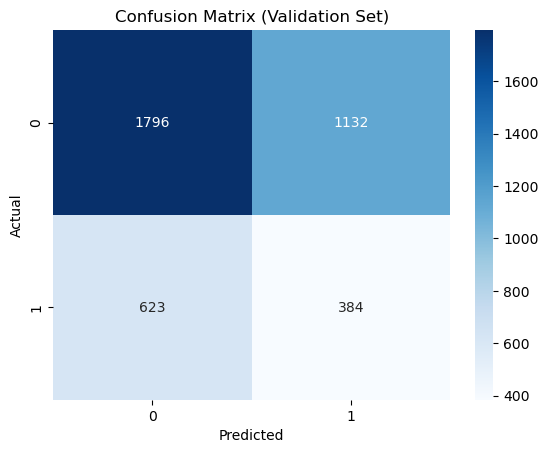

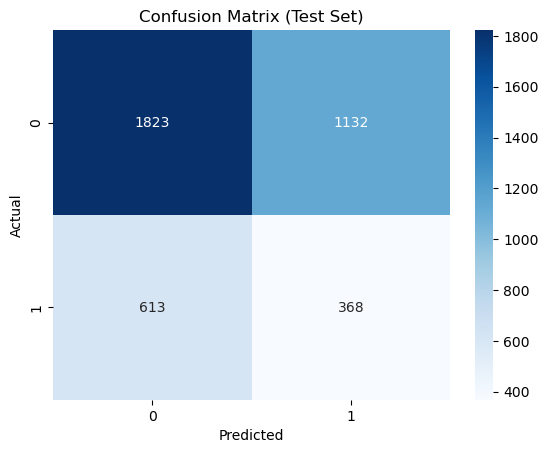

In [11]:
# Matriz de confusión para el conjunto de validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

# Matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()
